# $S_E/T$ - High T computation: Checks and grid

## Initial set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys 
sys.path.append("../src/RGE")

%run ../startup.py


📊 Plot style: using ps.apply_standard_formatting
✅ startup.py loaded: numpy, scipy, matplotlib, and project modules are ready.
   Use new_figure() to create pre-formatted plots.


In [3]:
# Paso 1: crear Veff con la ruta explícita
veff_obj = veff.VeffRGE(vt_table_path="../VT_integralNumeric.dat")

# Paso 2: pasarlo explícitamente al solver
solver_ht = bs_ht.BounceSolverHighT(veff=veff_obj)
fopt_ht = fopt.FOPTUtilities(veff_obj=veff_obj)


/Users/ramirezmaura/Documents/Projects/Supercool_transitions/codes/FOPT_project/.venv/lib/python3.9/site-packages/scipy/ndimage/_filters.py:1856: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


## Checking $S_E$ works properly

In [9]:
# === Parameters ===
gD0 = 0.6
scale = 4*np.pi
ls0 = 1e-10
T_vals = np.logspace(-5, np.log10(0.3), 35)  # ajusta rango según tu caso
S_vals = []

for T in tqdm(T_vals, desc="Computing S_E(T)"):
    try:
        S, phi_opt = solver_ht.SE(T, gD0, scale, ls0)
        S_vals.append(S)
    except Exception as e:
        print(f"⚠️ Failed at T={T:.3e}: {e}")
        S_vals.append(np.nan)


Computing S_E(T):   0%|          | 0/35 [00:00<?, ?it/s]/Users/ramirezmaura/Documents/Projects/Supercool_transitions/codes/FOPT_project/src/RGE/BounceSolHighT_RGE.py:158: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = quad(integrand, 0, phi0, limit=5000, epsrel=1e-6, epsabs=1e-6)[0]
Computing S_E(T):  20%|██        | 7/35 [07:14<28:40, 61.43s/it]/Users/ramirezmaura/Documents/Projects/Supercool_transitions/codes/FOPT_project/src/RGE/BounceSolHighT_RGE.py:158: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result = quad(integrand, 0, phi0, limit=5000, epsrel=1e-6, epsabs=1e-6)[0]
Computing S_E(T): 100%|██████████| 35/35 [32:32<00:00, 55.80s/it]


In [10]:
S_array = np.array(S_vals, dtype=float)

In [12]:
# Reemplaza ESTO:
# ax.axhline(140, color='gray', linestyle='--', label=r"Nucleation condition")

# POR ESTO:
def _H_backend(T):
    T = float(T)
    phi_min = solver_ht.phi_min_Veff0(T, gD0, scale, ls0)
    rhoH = -solver_ht.veff.Veff0_RGE(phi_min, T, gD0, scale, ls0) + (np.pi**2/30.0)*cs.g_dof*T**4
    return np.sqrt((8*np.pi*cs.GF/3.0) * rhoH)

H_vals   = np.array([_H_backend(T) for T in T_vals], dtype=float)
S_over_T = S_array / T_vals
eps = 1e-300
rhs = 4.0*np.log(T_vals) + 1.5*np.log(np.maximum(S_over_T/(2.0*np.pi), eps)) - 4.0*np.log(np.maximum(H_vals, eps))

# si llevas ylog=True, evita valores no positivos
mask = np.isfinite(rhs) & (rhs > 0)

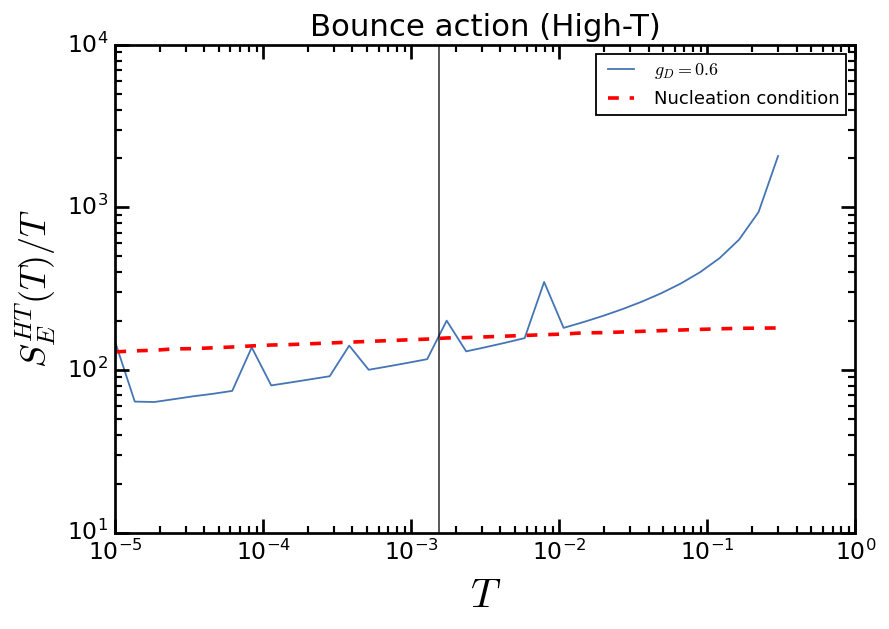

In [11]:

# === Plot with YOUR plot_style ===
fig, ax = new_figure(figsize=(7, 5), dpi=130)
fig.patch.set_facecolor('white')

ax.plot(T_vals,S_array/T_vals,
        color=ps.colors["HighT"],
        linestyle=ps.linestyles["Full"],
       # marker="o",
        label=fr"$g_D={gD0}$")

# Nucleation condition line
ax.plot(T_vals[mask], rhs[mask],
        color='red', linestyle='--', linewidth=2,
        label="Nucleation condition")

# marcar Tn por cruce (opcional)
y = (S_over_T - rhs)[mask]
Tm = T_vals[mask]
idx = np.where(np.sign(y[:-1]) * np.sign(y[1:]) < 0)[0]
if idx.size:
    i = idx[0]
    Tn = Tm[i] - y[i]*(Tm[i+1]-Tm[i])/(y[i+1]-y[i])  # interpolación lineal
    ax.axvline(Tn, color='k', lw=1, alpha=0.7)


# Apply your custom formatting
ps.apply_standard_formatting(ax,
                             xlabel=r"$T$",
                             ylabel=r"$S_E^{HT}(T)/T$",
                             title="Bounce action (High-T)",
                             xlog=True, ylog=True
                             )

# Legend
plt.style.use('classic')
plt.legend(loc="best", ncol=1, fontsize=10)

plt.tight_layout()



In [13]:
# # Saving the data
data = np.column_stack((T_vals, S_vals/T_vals))
np.savetxt("../data/raw_data/S_RGE_gD_0_6_4_mu_piT_ls0_1e-10.dat", data, header="T  S", comments='')

## Generating $S_E$ grid

In [5]:
# === Grid parameters ===
Tmax = np.log10(0.35)
T_vals = np.logspace(-5, Tmax, 75)         # 50 puntos en T
gD_vals = np.linspace(0.5, 1.0, 3)        # 25 puntos en gD
ls0 = 1e-10
scale = 0.25*np.pi

S_log_grid = np.empty((len(T_vals), len(gD_vals)))
S_log_grid[:] = np.nan  # inicializar con NaN

In [ ]:
for i, T in enumerate(tqdm(T_vals, desc="Temperatura")):
    for j, gD in enumerate(gD_vals):
        try:
            S_val = solver_ht.SE(T, gD,  scale , ls0)[0]  # numerical definition
            if S_val > 0 and np.isfinite(S_val):
                S_log_grid[i, j] = np.log10(S_val)
        except:
            pass  # put  NaN if needed

Temperatura:   0%|          | 0/75 [00:00<?, ?it/s]/Users/ramirezmaura/Documents/Projects/Supercool_transitions/codes/FOPT_project/src/RGE/BounceSolHighT_RGE.py:158: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = quad(integrand, 0, phi0, limit=5000, epsrel=1e-6, epsabs=1e-6)[0]
Temperatura:   9%|▉         | 7/75 [14:02<2:13:55, 118.17s/it]/Users/ramirezmaura/Documents/Projects/Supercool_transitions/codes/FOPT_project/src/RGE/BounceSolHighT_RGE.py:158: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result = quad(integrand, 0, phi0, limit=5000, epsrel=1e-6, epsabs=1e-6)[0]
Temperatura:  48%|████▊     | 36/75 [1:09:20<1:14:10, 114.12s/it]

In [ ]:
# === Optional: save grid ===
np.savez("../data/raw_data/SE_RGE_log_grid_HT_025piT.npz",
         S_log_grid=S_log_grid,
         T_vals=T_vals,
         gD_vals=gD_vals)


### Cleaning greed

In [7]:
data = np.load("../data/clean_data/SE_RGE_log_grid_HT_piT_cleaned.npz)
S_log_grid = data["S_log_grid"]
T_vals = data["T_vals"]
gD_vals = data["gD_vals"]

SyntaxError: EOL while scanning string literal (3732769883.py, line 1)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


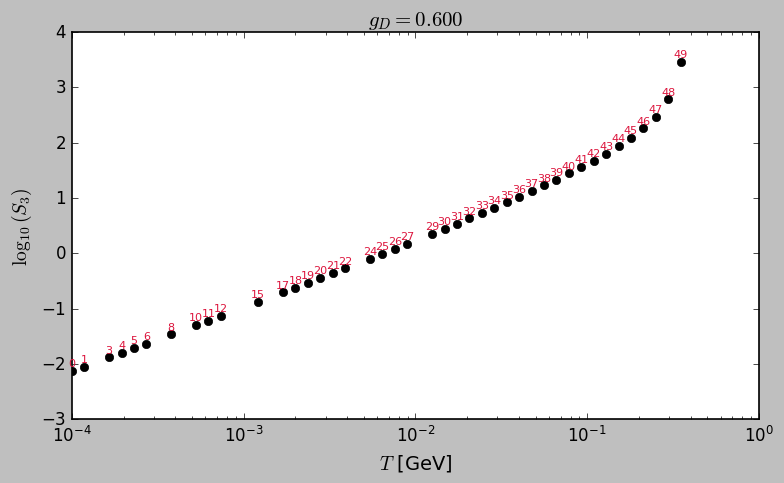

In [567]:
# === Paso 1: cargar la curva para un j fijo ===
j = 0 # o el índice gD que elijas
logS_vals = S_log_grid[:, j]  # esta es la columna de log10(S)
T_this = T_vals              # los T son iguales siempre

# === Paso 2: visualizar con índice de cada punto ===
plt.figure(figsize=(8, 5))
for i, (T, logS) in enumerate(zip(T_this, logS_vals)):
    plt.plot(T, logS, 'o', color='black')
    plt.text(T, logS + 0.05, str(i), fontsize=8, ha='center', va='bottom', color='crimson')  # muestra el índice i

plt.xscale('log')
plt.xlabel(r'$T$ [GeV]', fontsize=14)
plt.ylabel(r'$\log_{10}(S_3)$', fontsize=14)
plt.title(fr'$g_D = {gD_vals[j]:.3f}$', fontsize=15)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [558]:
# Creamos una copia para trabajar
logS_cleaned = S_log_grid.copy()

# Remover el punto específico (por índice visual)
i =25# el que viste en el plot
logS_cleaned[i, j] = np.nan  # lo marcamos como nan
S_log_grid[i, j] = logS_cleaned[i, j]

In [562]:
# Guarda el grid junto con los ejes
np.savez_compressed("../data/clean_data/SE_RGE_log_grid_HT_piT_cleaned.npz", 
                    S_log_grid=S_log_grid, 
                    T_vals=T_vals, 
                    gD_vals=gD_vals)

## Final plots of $S_E$-interpolation

In [27]:

# --- Cargar grid ---
data = np.load("../data/clean_data/SE_RGE_log_grid_HT_piT_cleaned.npz")
S_log_grid = data["S_log_grid"]
T_vals     = data["T_vals"]
gD_vals    = data["gD_vals"]

# --- Elegir columna exacta ---
j = 21
gD_exact = gD_vals[j]
col = S_log_grid[:, j]

# --- Limpiar datos (ignorar NaNs) ---
mask = np.isfinite(col)
T_clean = T_vals[mask]
SE_clean = 10.0**col[mask]
ST_clean = SE_clean / T_clean

In [28]:
# Reemplaza ESTO:
# ax.axhline(140, color='gray', linestyle='--', label=r"Nucleation condition")
gD0 =  gD_vals[j]
scale = np.pi
ls0 = 1e-10
# POR ESTO:
def _H_backend(T):
    T = float(T)
    phi_min = solver_ht.phi_min_Veff0(T, gD0, scale, ls0)
    rhoH = -solver_ht.veff.Veff0_RGE(phi_min, T, gD0, scale, ls0) + (np.pi**2/30.0)*cs.g_dof*T**4
    return np.sqrt((8*np.pi*cs.GF/3.0) * rhoH)

H_vals   = np.array([_H_backend(T) for T in T_clean], dtype=float)
S_over_T = SE_clean / T_clean
eps = 1e-300
rhs = 4.0*np.log(T_clean) + 1.5*np.log(np.maximum(S_over_T/(2.0*np.pi), eps)) - 4.0*np.log(np.maximum(H_vals, eps))

# si llevas ylog=True, evita valores no positivos
mask = np.isfinite(rhs) & (rhs > 0)

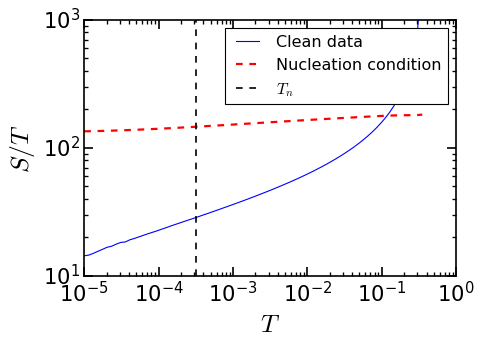

In [29]:


# # --- Ajuste spline ---
# spline = UnivariateSpline(T_clean, ST_clean, s=1e1)  # 's' controla suavizado
# T_dense = np.linspace(T_clean.min(), T_clean.max(), 400)
# ST_spline = spline(T_dense)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('white')
ax.plot(T_clean, ST_clean, label="Clean data")


# Nucleation condition line
ax.plot(T_clean[mask], rhs[mask],
        color='red', linestyle='--', linewidth=2,
        label="Nucleation condition")

ax.axvline(Tn, color='k', linestyle='--', lw=1.5, label=r"$T_n$")
ps.apply_standard_formatting(ax,
                             xlabel=r"$T$",
                             ylabel=r"$S/T$",
                             #title="Effective potential with RGE",
                             xlog = True, ylog=True,
                             ylim=(10,1e3)
                            )
plt.style.use('classic')
ax.legend()
plt.show()


## FOPT parameters

In [30]:
#nucTemp(self, gD, is_HT=False, scale=None, ls0=cs.lambdaS0)

In [31]:
gD0 = gD_vals[j]
gD0

np.float64(0.8088235294117647)

In [32]:
Tn = fopt_ht.nucTemp(gD=gD0, is_HT=True)
Tn

np.float64(0.11771948082917232)

In [33]:
alpha =fopt_ht.alpha(Tn, gD0, is_HT=True, scale =np.pi )
alpha

5.605770101909313

In [34]:
beta = fopt_ht.beta(Tn, gD0)
beta

133.7646014544273

In [35]:
print(f'gD = {gD0}, Tn={Tn}, alpha={alpha}, beta={beta}')

gD = 0.8088235294117647, Tn=0.11771948082917232, alpha=5.605770101909313, beta=133.7646014544273


### Plots

In [ ]:
alpha_vals = []
for gD, Tn in zip(gD_vals, Tn_vals):
    if np.isfinite(Tn):
        alpha_vals.append()
    else:
        alpha_vals.append(np.nan)

alpha_vals = np.array(alpha_vals)


In [775]:
alpha_vals

array([6.18697781e+11, 6.81412622e+10, 9.32017683e+09, 3.16593874e+08,
       2.97226582e+07, 8.30942847e+06, 1.95645056e+06, 1.34014983e+05,
       5.41577208e+04, 1.84824774e+04, 4.71563338e+03, 1.31043839e+03,
       5.42518842e+02, 2.85078250e+02, 1.66145116e+02, 9.99614298e+01,
       5.72326232e+01, 3.52457115e+01, 2.14895397e+01, 1.11998699e+01,
       8.33127282e+00, 5.60577010e+00, 3.62180469e+00, 3.02649242e+00,
       2.19354522e+00, 1.91156020e+00, 1.36329395e+00, 1.11825703e+00,
       9.37121302e-01, 8.66511619e-01, 6.85658002e-01, 6.49776616e-01,
       5.39385007e-01, 4.86774869e-01, 4.47517149e-01])

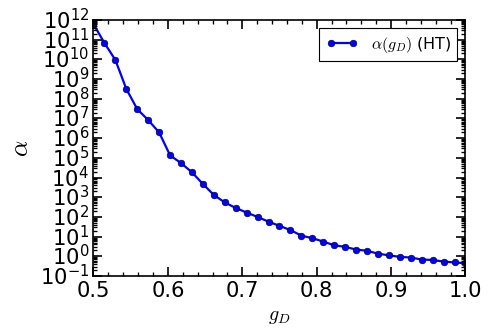

In [784]:
fig, ax = new_figure(figsize=(6,4))
fig.patch.set_facecolor('white')
plt.plot(gD_vals, alpha_vals, "o-", lw=2, label=r"$\alpha(g_D)$ (HT)")

ps.apply_standard_formatting(ax,
                             xlabel=r"$g_D$",
                             ylabel=r"$\alpha$",
                             #title="Effective potential with RGE",
                             xlog = False, ylog=True
                            )
plt.legend()
plt.show()


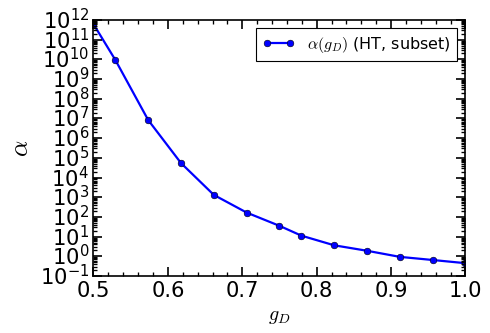

In [783]:
n_select = 13
idx = np.linspace(0, len(gD_vals)-1, n_select, dtype=int)

fig, ax = new_figure(figsize=(6,4))
fig.patch.set_facecolor('white')
plt.plot(gD_vals[idx], alpha_vals[idx], "o-", lw=2, label=r"$\alpha(g_D)$ (HT, subset)")
ps.apply_standard_formatting(ax,
                             xlabel=r"$g_D$",
                             ylabel=r"$\alpha$",
                             #title="Effective potential with RGE",
                             xlog = False, ylog=True
                            )
plt.legend()
plt.show()


In [811]:
beta_vals = []
for gD, Tn in zip(gD_vals, Tn_vals):
    if np.isfinite(Tn):
        beta_vals.append(fopt_ht.beta(Tn, gD))
    else:
        beta_vals.append(np.nan)

beta_vals = np.array(beta_vals)


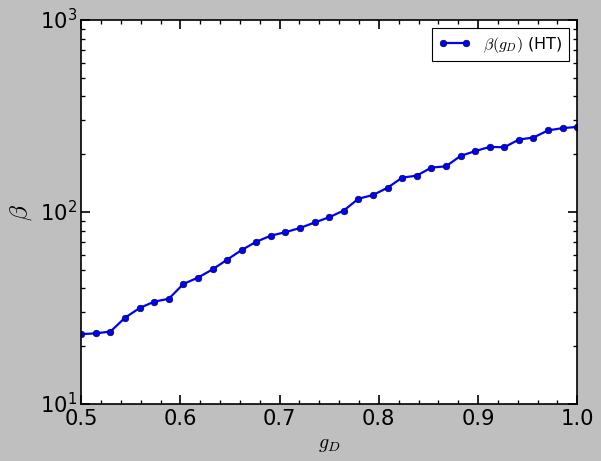

In [812]:
fig, ax = plt.subplots()

ax.plot(gD_vals, beta_vals, "o-", lw=2, label=r"$\beta(g_D)$ (HT)")

ps.apply_standard_formatting(ax,
                             xlabel=r"$g_D$",
                             ylabel=r"$\beta$",
                             xlog=False, ylog=True)

ax.legend()
plt.show()


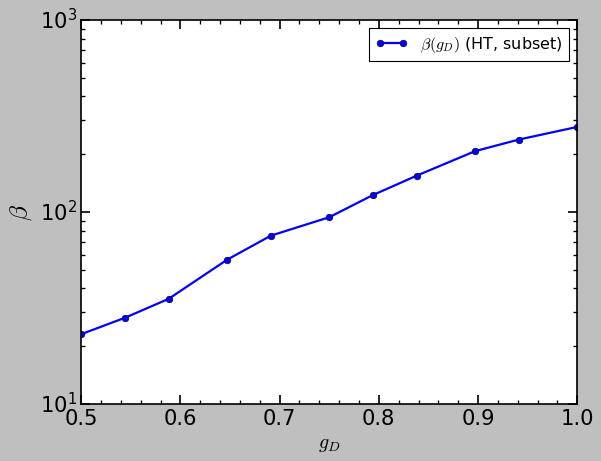

In [814]:
n_select = 11
idx = np.linspace(0, len(gD_vals)-1, n_select, dtype=int)

fig, ax = plt.subplots()

ax.plot(gD_vals[idx], beta_vals[idx], "o-", lw=2, label=r"$\beta(g_D)$ (HT, subset)")

ps.apply_standard_formatting(ax,
                             xlabel=r"$g_D$",
                             ylabel=r"$\beta$",
                             xlog=False, ylog=True)

ax.legend()
plt.show()


In [815]:


# stack columnas
data_all = np.column_stack([gD_vals, Tn_vals, alpha_vals, beta_vals])

# guardar como .dat con header
np.savetxt("../data/final_data/gD_Tn_alpha_beta_RGE_piT_HT_all.dat", data_all,
           header="gD    Tn    alpha    beta",
           fmt="%.6e")


In [816]:
n_select = 13
idx = np.linspace(0, len(gD_vals)-1, n_select, dtype=int)

data_sel = data_all[idx]

np.savetxt("../data/final_data/gD_Tn_alpha_beta_RGE_piT_HT_subset.dat", data_sel,
           header="gD    Tn    alpha    beta",
           fmt="%.6e")
